In [1]:
# install libraries for Google Colab
!pip install --upgrade tables
!pip install eli5
!pip install scikit-plot
!pip install xgboost
!pip install hyperopt

     |████████████████████████████████| 4.3MB 2.7MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4
     |████████████████████████████████| 112kB 2.7MB/s 


In [2]:
# import libraries

import pandas as pd
import numpy as np
import joblib

from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit, train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler

# import models
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

# Hyperparameter Optimization
from functools import partial
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import eli5
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances

#visualization
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
base_color = sns.color_palette()[0]
import scikitplot as skplt

import warnings
warnings.filterwarnings('ignore')

#show all columns and rows
pd.options.display.max_rows = None
pd.options.display.max_columns = None


random_state=2020

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pand

## Load the data

In [3]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
cd '/content/drive/My Drive/Colab Notebooks/DataWorkshop_Competition_Warsaw_Air_Pollution'

/content/drive/My Drive/Colab Notebooks/DataWorkshop_Competition_Warsaw_Air_Pollution


In [5]:
# load the wrangled and transformed data 
df = pd.read_hdf('data/warsaw_air_pollution_2015-2019_feature_eng.h5', key='df')

In [6]:
df.head()

,datetime,apparentTemperature,cloudCover,dewPoint,humidity,icon,precipIntensity,precipProbability,pressure,summary,temperature,uvIndex,visibility,windBearing,windSpeed,PM25_nie,PM25_wok,hour,day,dayofyear,weekday,month,year,IsWeekend,PM25_nie_mean,PM25_wok_mean,humidity_log,windSpeed_log,PM25_nie_log,PM25_wok_log,apparentTemperature_lag1h,cloudCover_lag1h,dewPoint_lag1h,humidity_lag1h,humidity_log_lag1h,precipIntensity_lag1h,precipProbability_lag1h,pressure_lag1h,temperature_lag1h,uvIndex_lag1h,visibility_lag1h,windBearing_lag1h,windSpeed_lag1h,windSpeed_log_lag1h,apparentTemperature_lag24h,cloudCover_lag24h,dewPoint_lag24h,humidity_lag24h,humidity_log_lag24h,precipIntensity_lag24h,precipProbability_lag24h,pressure_lag24h,temperature_lag24h,uvIndex_lag24h,visibility_lag24h,windBearing_lag24h,windSpeed_lag24h,windSpeed_log_lag24h,apparentTemperature_rolling12h,cloudCover_rolling12h,dewPoint_rolling12h,humidity_rolling12h,humidity_log_rolling12h,precipIntensity_rolling12h,precipProbability_rolling12h,pressure_rolling12h,temperature_rolling12h,uvIndex_rolling12h,visibility_rolling12h,windBearing_rolling12h,windSpeed_rolling12h,windSpeed_log_rolling12h,apparentTemperature_rolling24h,cloudCover_rolling24h,dewPoint_rolling24h,humidity_rolling24h,humidity_log_rolling24h,precipIntensity_rolling24h,precipProbability_rolling24h,pressure_rolling24h,temperature_rolling24h,uvIndex_rolling24h,visibility_rolling24h,windBearing_rolling24h,windSpeed_rolling24h,windSpeed_log_rolling24h,apparentTemperature_rolling72h,cloudCover_rolling72h,dewPoint_rolling72h,humidity_rolling72h,humidity_log_rolling72h,precipIntensity_rolling72h,precipProbability_rolling72h,pressure_rolling72h,temperature_rolling72h,uvIndex_rolling72h,visibility_rolling72h,windBearing_rolling72h,windSpeed_rolling72h,windSpeed_log_rolling72h,apparentTemperature_rolling168h,cloudCover_rolling168h,dewPoint_rolling168h,humidity_rolling168h,humidity_log_rolling168h,precipIntensity_rolling168h,precipProbability_rolling168h,pressure_rolling168h,temperature_rolling168h,uvIndex_rolling168h,visibility_rolling168h,windBearing_rolling168h,windSpeed_rolling168h,windSpeed_log_rolling168h,mean_apparentTemperature_per_day,mean_cloudCover_per_day,mean_dewPoint_per_day,mean_humidity_per_day,mean_humidity_log_per_day,mean_precipIntensity_per_day,mean_precipProbability_per_day,mean_pressure_per_day,mean_temperature_per_day,mean_uvIndex_per_day,mean_visibility_per_day,mean_windBearing_per_day,mean_windSpeed_per_day,mean_windSpeed_log_per_day,mean_PM25_nie_per_day,mean_PM25_wok_per_day,mean_PM25_nie_log_per_day,mean_PM25_wok_log_per_day,median_apparentTemperature_per_day,median_cloudCover_per_day,median_dewPoint_per_day,median_humidity_per_day,median_humidity_log_per_day,median_precipIntensity_per_day,median_precipProbability_per_day,median_pressure_per_day,median_temperature_per_day,median_uvIndex_per_day,median_visibility_per_day,median_windBearing_per_day,median_windSpeed_per_day,median_windSpeed_log_per_day,median_PM25_nie_per_day,median_PM25_wok_per_day,median_PM25_nie_log_per_day,median_PM25_wok_log_per_day,mean_apparentTemperature_per_month,mean_cloudCover_per_month,mean_dewPoint_per_month,mean_humidity_per_month,mean_humidity_log_per_month,mean_precipIntensity_per_month,mean_precipProbability_per_month,mean_pressure_per_month,mean_temperature_per_month,mean_uvIndex_per_month,mean_visibility_per_month,mean_windBearing_per_month,mean_windSpeed_per_month,mean_windSpeed_log_per_month,mean_PM25_nie_per_month,mean_PM25_wok_per_month,mean_PM25_nie_log_per_month,mean_PM25_wok_log_per_month,median_apparentTemperature_per_month,median_cloudCover_per_month,median_dewPoint_per_month,median_humidity_per_month,median_humidity_log_per_month,median_precipIntensity_per_month,median_precipProbability_per_month,median_pressure_per_month,median_temperature_per_month,median_uvIndex_per_month,median_visibility_per_month,median_windBearing_per_month,median_windSpeed_per_month,median_windSpeed_log_per_month,median_PM

In [ ]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43848 entries, 0 to 43847
Data columns (total 212 columns):
 #   Column                                  Dtype         
---  ------                                  -----         
 0   datetime                                datetime64[ns]
 1   apparentTemperature                     float64       
 2   cloudCover                              float64       
 3   dewPoint                                float64       
 4   humidity                                float64       
 5   icon                                    object        
 6   precipIntensity                         float64       
 7   precipProbability                       float64       
 8   pressure                                float64       
 9   summary                                 object        
 10  temperature                             float64       
 11  uvIndex                                 float64       
 12  visibility                              float

#### Split the data for train and test

In [7]:
# split the df for train and test, leave last 6 month for the test
train_mask = df['datetime'] < '2019-07-01'
test_mask = df['datetime'] >= '2019-07-01'

df_train = df.loc[train_mask]
df_test = df.loc[test_mask]

In [8]:
# check if the train dataset is correctly split
df_train.datetime.min(), df_train.datetime.max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2019-06-30 23:00:00'))

In [9]:
# check if the test dataset is correctly split
df_test.datetime.min(), df_test.datetime.max()

(Timestamp('2019-07-01 00:00:00'), Timestamp('2019-12-31 23:00:00'))

## Create functions for quick iterations and scoring

In [10]:
# function to run different models
def run_model(feats, model, cross_val):
    X = df_train[feats].values
    y = df_train['PM25_nie_log'].values
    
    model_name = type(model).__name__

    rmse = np.sqrt(-cross_val_score(model, X, y, cv=cross_val, scoring='neg_mean_squared_error'))
    r2 = cross_val_score(model, X, y, cv=cross_val, scoring='r2')
    print("{} RMSE: {:.4f}, r2: {:.1f}%".format(model_name, np.mean(rmse), 100*np.mean(r2)))

In [11]:
# function to plot a learning curve for different models and scoring
def plot_lear_curve(feats, model, cross_val, scoring, ax):

  X = df_train[feats].values
  y = df_train['PM25_nie_log'].values

  model_name = type(model).__name__

  skplt.estimators.plot_learning_curve(model, X, y, cv=cross_val, scoring=scoring,
                                       title=f'{model_name} Learning Curve', ax=ax);

##Define cross-validation and initiate simple models for benchmarking purpose

In [12]:
# define Cross Validation
tcsv = TimeSeriesSplit(n_splits=5)
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

# define simple models for fast testing
Dummy_model = DummyRegressor(strategy="mean")
DT_model = DecisionTreeRegressor(max_depth=3, random_state=random_state)
RF_model = RandomForestRegressor(max_depth=3, random_state=random_state)
XGB_model = xgb.XGBRegressor(max_depth=3, objective='reg:squarederror', random_state=random_state)
LGBM_model = lgb.LGBMRegressor(max_depth=3, objective='regression', random_state=random_state)

# add all models to a list
models = [Dummy_model, DT_model, RF_model, XGB_model, LGBM_model]

###Run models on original darksky.net features

In [13]:
# select original features from darksky.net
orig_feats = ['cloudCover', 'dewPoint', 'humidity', 'precipIntensity',
              'precipProbability', 'pressure', 'temperature', 'uvIndex',
              'visibility', 'windBearing', 'windSpeed', 'icon_num']

In [14]:
# run models on time series split
for model in models:
    run_model(orig_feats, model, tcsv)

DummyRegressor RMSE: 0.6046, r2: -8.8%
DecisionTreeRegressor RMSE: 0.4983, r2: 23.5%
RandomForestRegressor RMSE: 0.4819, r2: 28.6%
XGBRegressor RMSE: 0.4579, r2: 31.4%
LGBMRegressor RMSE: 0.4612, r2: 29.9%


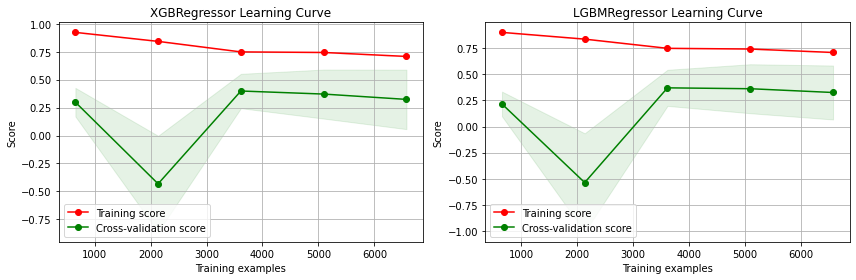

In [15]:
# check r2 learning curve for models ran on time series split
fig=plt.figure(figsize=(12,4))
for i, model in enumerate(models[3:]):
    ax=fig.add_subplot(1,2,i+1)
    plot_lear_curve(orig_feats, model, tcsv, 'r2', ax=ax)
fig.tight_layout()
plt.show()

In [16]:
# run models on KFold
for model in models:
    run_model(orig_feats, model, kf)

DummyRegressor RMSE: 0.6104, r2: -0.0%
DecisionTreeRegressor RMSE: 0.4769, r2: 39.0%
RandomForestRegressor RMSE: 0.4716, r2: 40.3%
XGBRegressor RMSE: 0.3975, r2: 57.6%
LGBMRegressor RMSE: 0.3972, r2: 57.7%


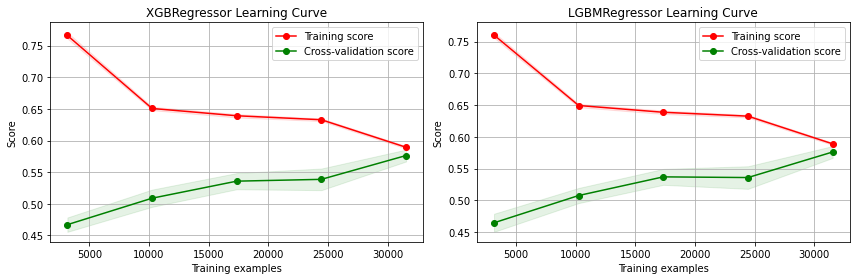

In [17]:
# check r2 learning curve for models ran on KFold
fig=plt.figure(figsize=(12,4))
for i, model in enumerate(models[3:]):
    ax=fig.add_subplot(1,2,i+1)
    plot_lear_curve(orig_feats, model, kf, 'r2', ax=ax)
fig.tight_layout()
plt.show()

###Run models on original darksky.net features extended with time based features

In [18]:
# extend original features with new time based ones
time_feats = ['cloudCover', 'dewPoint', 'humidity', 'precipIntensity', 'precipProbability',
              'pressure', 'temperature', 'uvIndex', 'visibility', 'windBearing', 'windSpeed',
              'icon_num', 'Autumn', 'Spring', 'Summer', 'Winter',
              'year', 'month', 'day', 'dayofyear', 'hour', 'weekday', 'IsWeekend']

In [19]:
# run models on time series split
for model in models:
    run_model(time_feats, model, tcsv)

DummyRegressor RMSE: 0.6046, r2: -8.8%
DecisionTreeRegressor RMSE: 0.5104, r2: 19.3%
RandomForestRegressor RMSE: 0.4925, r2: 25.1%
XGBRegressor RMSE: 0.3997, r2: 50.7%
LGBMRegressor RMSE: 0.3983, r2: 50.9%


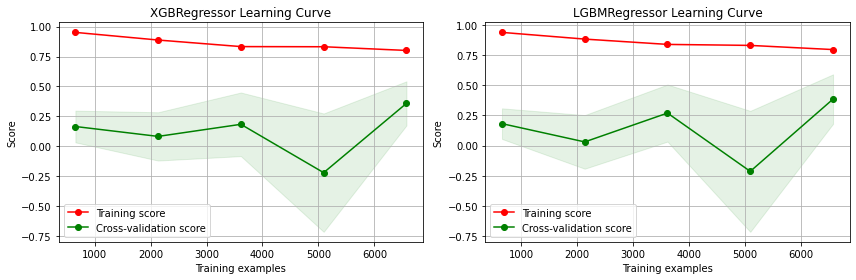

In [20]:
# check r2 learning curve for models ran on time series split
fig=plt.figure(figsize=(12,4))
for i, model in enumerate(models[3:]):
    ax=fig.add_subplot(1,2,i+1)
    plot_lear_curve(time_feats, model, tcsv, 'r2', ax=ax)
fig.tight_layout()
plt.show()

In [21]:
# run models on KFold
for model in models:
    run_model(time_feats, model, kf)

DummyRegressor RMSE: 0.6104, r2: -0.0%
DecisionTreeRegressor RMSE: 0.4706, r2: 40.5%
RandomForestRegressor RMSE: 0.4644, r2: 42.1%
XGBRegressor RMSE: 0.3504, r2: 67.0%
LGBMRegressor RMSE: 0.3499, r2: 67.1%


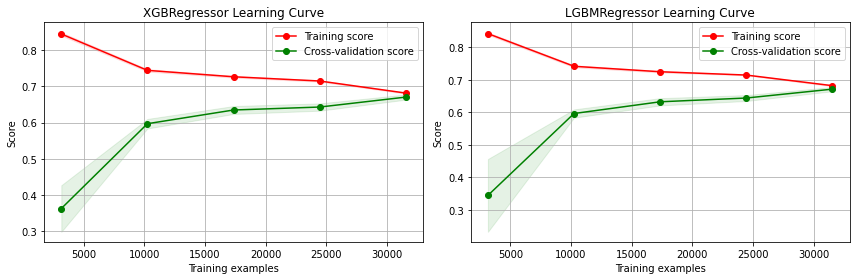

In [22]:
# check r2 learning curve for models ran on KFold
fig=plt.figure(figsize=(12,4))
for i, model in enumerate(models[3:]):
    ax=fig.add_subplot(1,2,i+1)
    plot_lear_curve(time_feats, model, kf, 'r2', ax=ax)
fig.tight_layout()
plt.show()

###Run models on all features except features realted to PM2.5

In [23]:
# function to get all numerical features, except the one related to PM2.5 and Wokalna Street measures
def get_feats(df):
    feats = df.select_dtypes([np.number, np.bool]).columns
    black_list = [
                  # Niepodleglosci
                  'PM25_nie', 'PM25_nie_log', 'PM25_nie_mean', 'mean_PM25_nie_per_day',
                  'mean_PM25_nie_log_per_day', 'median_PM25_nie_per_day', 'median_PM25_nie_log_per_day',
                  'mean_PM25_nie_per_month', 'mean_PM25_nie_log_per_month', 'median_PM25_nie_per_month',
                  'median_PM25_nie_log_per_month',
                  # Wokalna
                  'PM25_wok', 'PM25_wok_log', 'PM25_wok_mean', 'mean_PM25_wok_per_day', 
                  'mean_PM25_wok_log_per_day', 'median_PM25_wok_per_day', 'median_PM25_wok_log_per_day',
                  'mean_PM25_wok_per_month', 'mean_PM25_wok_log_per_month', 'median_PM25_wok_per_month',
                  'median_PM25_wok_log_per_month'
                  ]
                  
    return [x for x in feats if x not in black_list]

In [24]:
#get feats
feats = get_feats(df_train)

In [25]:
# run models on time series split
for model in models[1:]:
    run_model(feats, model, tcsv)

DecisionTreeRegressor RMSE: 0.5067, r2: 20.0%
RandomForestRegressor RMSE: 0.4669, r2: 32.3%
XGBRegressor RMSE: 0.3658, r2: 58.3%
LGBMRegressor RMSE: 0.3664, r2: 58.2%


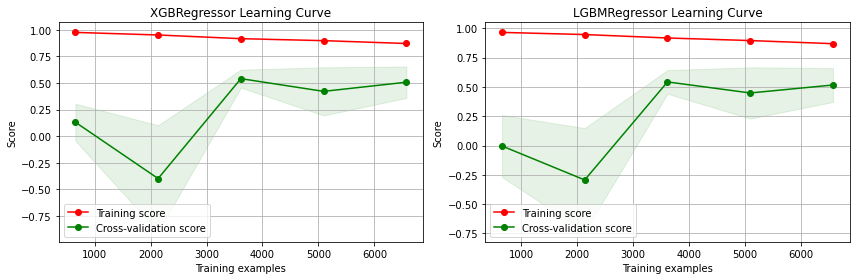

In [26]:
# check r2 learning curve for models ran on time series split
fig=plt.figure(figsize=(12,4))
for i, model in enumerate(models[3:]):
    ax=fig.add_subplot(1,2,i+1)
    plot_lear_curve(feats, model, tcsv, 'r2', ax=ax)
fig.tight_layout()
plt.show()

In [27]:
# run models on KFold
for model in models[1:]:
    run_model(feats, model, kf)

DecisionTreeRegressor RMSE: 0.4373, r2: 48.7%
RandomForestRegressor RMSE: 0.4264, r2: 51.2%
XGBRegressor RMSE: 0.3020, r2: 75.5%
LGBMRegressor RMSE: 0.3017, r2: 75.6%


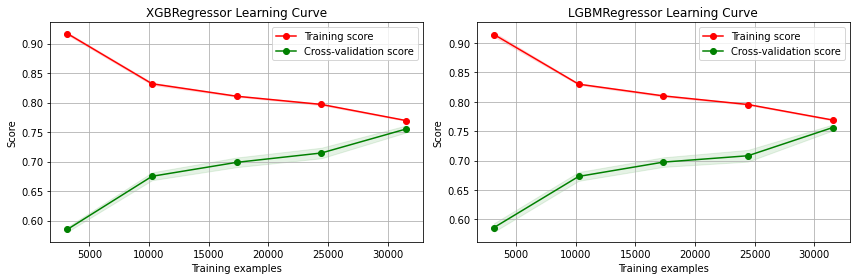

In [28]:
# check r2 learning curve for models ran on KFold
fig=plt.figure(figsize=(12,4))
for i, model in enumerate(models[3:]):
    ax=fig.add_subplot(1,2,i+1)
    plot_lear_curve(feats, model, kf, 'r2', ax=ax)
fig.tight_layout()
plt.show()

##Parameters tuning with HyperOpt on all features except features realted to PM2.5

###XGBoost Depth-wise

In [29]:
X = df_train[feats].values
y = df_train['PM25_nie_log'].values

def objective(space):
    
    XGB_model = xgb.XGBRegressor(n_estimators = space['n_estimators'],
                           max_depth = int(space['max_depth']),
                           min_child_weight = space['min_child_weight'],
                           subsample = space['subsample'],
                           learning_rate = space['learning_rate'],
                           gamma = space['gamma'],
                           colsample_bytree = space['colsample_bytree'],
                           objective='reg:squarederror',
                           tree_method='hist',
                           grow_policy='depthwise',
                           random_state=random_state
                           )
    
    for train_idx, test_idx in kf.split(X):

        eval_set = [(X[train_idx], y[train_idx]), (X[test_idx], y[test_idx])]
        XGB_model.fit(X[train_idx], y[train_idx], eval_set=eval_set, eval_metric = 'rmse', early_stopping_rounds=10, verbose=False)
        y_pred = XGB_model.predict(X[test_idx])

        rmse = np.sqrt(mean_squared_error(y[test_idx], y_pred))
        r2 = r2_score(y[test_idx], y_pred)
        
        print("RMSE: {:.4f}, r2: {:.1f}%".format(rmse, 100*r2))
        return{'loss': rmse, 'status': STATUS_OK }
    
    
space ={
        'max_depth': hp.choice('max_depth', np.arange(2, 8, 1, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
        'subsample': hp.uniform('subsample', 0.7, 1),
        'n_estimators' : hp.choice('n_estimators', np.arange(10, 500, 2, dtype=int)),
        'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05)
    }

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=10,
            trials=trials)

print("The best params: ", best)

RMSE: 0.2701, r2: 80.5%
RMSE: 0.2634, r2: 81.5%
RMSE: 0.2234, r2: 86.7%
RMSE: 0.2573, r2: 82.3%
RMSE: 0.2318, r2: 85.7%
RMSE: 0.2067, r2: 88.6%
RMSE: 0.2188, r2: 87.2%
RMSE: 0.2135, r2: 87.8%
RMSE: 0.2048, r2: 88.8%
RMSE: 0.1922, r2: 90.1%
100%|██████████| 10/10 [04:59<00:00, 29.95s/it, best loss: 0.19220275695435196]
The best params:  {'colsample_bytree': 0.8500000000000001, 'gamma': 0.65, 'learning_rate': 0.15000000000000002, 'max_depth': 5, 'min_child_weight': 4.0, 'n_estimators': 93, 'subsample': 0.8191776454687095}


In [30]:
# initite model with best parameters
XGB_model_depth = xgb.XGBRegressor(**best, objective='reg:squarederror', tree_method='hist', grow_policy='depthwise', random_state=random_state)
XGB_model_depth.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8500000000000001,
             gamma=0.65, grow_policy='depthwise', importance_type='gain',
             learning_rate=0.15000000000000002, max_delta_step=0, max_depth=5,
             min_child_weight=4.0, missing=None, n_estimators=93, n_jobs=1,
             nthread=None, objective='reg:squarederror', random_state=2020,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8191776454687095, tree_method='hist',
             verbosity=1)

In [31]:
perm = PermutationImportance(XGB_model_depth).fit(X, y)
eli5.show_weights(perm, feature_names=feats, top=30)

Weight,Feature
0.1720 ± 0.0014,mean_apparentTemperature_per_month
0.0383 ± 0.0009,windSpeed_rolling24h
0.0300 ± 0.0006,windSpeed_rolling12h
0.0300 ± 0.0015,visibility
0.0236 ± 0.0002,dewPoint
0.0212 ± 0.0003,hour
0.0199 ± 0.0009,windSpeed_lag1h
0.0184 ± 0.0003,dewPoint_rolling168h
0.0172 ± 0.0006,year
0.0143 ± 0.0006,median_apparentTemperature_per_day


###XGBoost Leaf-wise

In [32]:
def objective(space):
    
    XGB_model = xgb.XGBRegressor(n_estimators = space['n_estimators'],
                           max_depth = int(space['max_depth']),
                           min_child_weight = space['min_child_weight'],
                           subsample = space['subsample'],
                           learning_rate = space['learning_rate'],
                           gamma = space['gamma'],
                           colsample_bytree = space['colsample_bytree'],
                           objective='reg:squarederror',
                           tree_method='hist',
                           grow_policy='lossguide',
                           random_state=random_state
                           )
    
    for train_idx, test_idx in kf.split(X):

        eval_set = [(X[train_idx], y[train_idx]), (X[test_idx], y[test_idx])]
        XGB_model.fit(X[train_idx], y[train_idx], eval_set=eval_set, eval_metric = 'rmse', early_stopping_rounds=10, verbose=False)
        y_pred = XGB_model.predict(X[test_idx])

        rmse = np.sqrt(mean_squared_error(y[test_idx], y_pred))
        r2 = r2_score(y[test_idx], y_pred)
        
        print("RMSE: {:.4f}, r2: {:.1f}%".format(rmse, 100*r2))
        return{'loss': rmse, 'status': STATUS_OK }
    
    
space ={
        'max_depth': hp.choice('max_depth', np.arange(2, 8, 1, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
        'subsample': hp.uniform('subsample', 0.7, 1),
        'n_estimators' : hp.choice('n_estimators', np.arange(10, 500, 2, dtype=int)),
        'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05)
    }

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=10,
            trials=trials)

print("The best params: ", best)

RMSE: 0.2116, r2: 88.0%
RMSE: 0.2153, r2: 87.6%
RMSE: 0.2021, r2: 89.1%
RMSE: 0.2052, r2: 88.8%
RMSE: 0.2229, r2: 86.7%
RMSE: 0.2432, r2: 84.2%
RMSE: 0.2446, r2: 84.0%
RMSE: 0.3402, r2: 69.1%
RMSE: 0.1979, r2: 89.6%
RMSE: 0.1890, r2: 90.5%
100%|██████████| 10/10 [05:49<00:00, 34.94s/it, best loss: 0.18898877888118476]
The best params:  {'colsample_bytree': 0.6000000000000001, 'gamma': 0.6000000000000001, 'learning_rate': 0.17500000000000002, 'max_depth': 5, 'min_child_weight': 8.0, 'n_estimators': 183, 'subsample': 0.773386168092445}


In [33]:
XGB_model_leaf = xgb.XGBRegressor(**best, objective='reg:squarederror', tree_method='hist', grow_policy='lossguide', random_state=random_state)
XGB_model_leaf.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6000000000000001,
             gamma=0.6000000000000001, grow_policy='lossguide',
             importance_type='gain', learning_rate=0.17500000000000002,
             max_delta_step=0, max_depth=5, min_child_weight=8.0, missing=None,
             n_estimators=183, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=2020, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.773386168092445, tree_method='hist', verbosity=1)

In [34]:
perm = PermutationImportance(XGB_model_leaf).fit(X, y)
eli5.show_weights(perm, feature_names=feats, top=30)

Weight,Feature
0.0453 ± 0.0007,mean_apparentTemperature_per_month
0.0388 ± 0.0010,temperature_rolling168h
0.0329 ± 0.0006,visibility
0.0307 ± 0.0009,windSpeed_rolling24h
0.0254 ± 0.0003,uvIndex_rolling168h
0.0229 ± 0.0006,windSpeed_rolling12h
0.0219 ± 0.0005,hour
0.0195 ± 0.0002,dewPoint
0.0180 ± 0.0006,dewPoint_rolling168h
0.0162 ± 0.0003,windSpeed_lag1h


###LightGBM

In [35]:
def objective(space):
    
    LGBM_model = lgb.LGBMRegressor(
                max_depth = int(space['max_depth']),
                n_estimators = space['n_estimators'],
                num_leaves = space['num_leaves'],
                min_child_weight = space['min_child_weight'],
                subsample = space['subsample'],
                learning_rate = space['learning_rate'],
                gamma = space['gamma'],
                colsample_bytree = space['colsample_bytree'],
                objective='regression',
                random_state=random_state
                )
    
    for train_idx, test_idx in kf.split(X):

        eval_set = [(X[train_idx], y[train_idx]), (X[test_idx], y[test_idx])]
        LGBM_model.fit(X[train_idx], y[train_idx], eval_set=eval_set, eval_metric = 'rmse', early_stopping_rounds=10, verbose=False)
        y_pred = LGBM_model.predict(X[test_idx])

        rmse = np.sqrt(mean_squared_error(y[test_idx], y_pred))
        r2 = r2_score(y[test_idx], y_pred)
        
        print("RMSE: {:.4f}, r2: {:.1f}%".format(rmse, 100*r2))
        return{'loss': rmse, 'status': STATUS_OK }
    
    
space ={
        'max_depth': hp.choice('max_depth', np.arange(2, 8, 1, dtype=int)),
        'n_estimators' : hp.choice('n_estimators', np.arange(10, 500, 2, dtype=int)),
        'num_leaves' : hp.choice('num_leaves', np.arange(10, 30, 1, dtype=int)),
        'min_child_weight': hp.quniform ('min_child_weight', 1, 10, 1),
        'subsample': hp.uniform('subsample', 0.7, 1),
        'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05)
        }

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=10,
            trials=trials)

print("The best params: ", best)

RMSE: 0.1966, r2: 89.7%
RMSE: 0.1987, r2: 89.5%
RMSE: 0.2624, r2: 81.6%
RMSE: 0.1854, r2: 90.8%
RMSE: 0.1888, r2: 90.5%
RMSE: 0.2242, r2: 86.6%
RMSE: 0.3078, r2: 74.7%
RMSE: 0.2154, r2: 87.6%
RMSE: 0.1843, r2: 90.9%
RMSE: 0.2644, r2: 81.4%
100%|██████████| 10/10 [01:32<00:00,  9.21s/it, best loss: 0.1842914942546308]
The best params:  {'colsample_bytree': 0.8500000000000001, 'gamma': 0.8500000000000001, 'learning_rate': 0.5, 'max_depth': 5, 'min_child_weight': 4.0, 'n_estimators': 163, 'num_leaves': 9, 'subsample': 0.9122649615581006}


In [36]:
# initite model with best parameters
LGBM_model = lgb.LGBMRegressor(**best, objective='regression', random_state=random_state)
LGBM_model.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.8500000000000001, gamma=0.8500000000000001,
              importance_type='split', learning_rate=0.5, max_depth=5,
              min_child_samples=20, min_child_weight=4.0, min_split_gain=0.0,
              n_estimators=163, n_jobs=-1, num_leaves=9, objective='regression',
              random_state=2020, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=0.9122649615581006, subsample_for_bin=200000,
              subsample_freq=0)

In [37]:
perm = PermutationImportance(LGBM_model).fit(X, y)
eli5.show_weights(perm, feature_names=feats, top=30)

Weight,Feature
0.1316 ± 0.0018,mean_uvIndex_per_month
0.0440 ± 0.0006,mean_dewPoint_per_month
0.0412 ± 0.0005,windSpeed_rolling24h
0.0400 ± 0.0010,temperature_rolling168h
0.0340 ± 0.0010,dewPoint
0.0305 ± 0.0009,windSpeed_lag1h
0.0273 ± 0.0004,windSpeed_log_rolling12h
0.0243 ± 0.0006,hour
0.0240 ± 0.0005,year
0.0239 ± 0.0004,humidity_lag1h


###Models evaluation

In [38]:
models = [XGB_model_depth, XGB_model_leaf, LGBM_model]

for model in models:
    run_model(feats, model, kf)

XGBRegressor RMSE: 0.2366, r2: 85.0%
XGBRegressor RMSE: 0.2094, r2: 88.2%
LGBMRegressor RMSE: 0.2252, r2: 86.4%


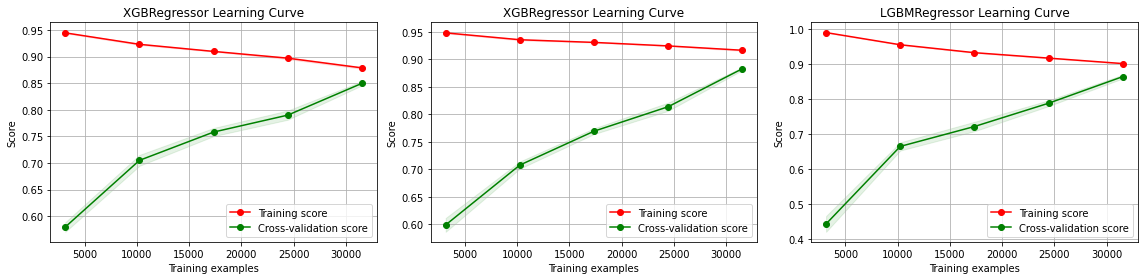

In [39]:
fig=plt.figure(figsize=(16,4))
for i, model in enumerate(models):
    ax=fig.add_subplot(1,3,i+1)
    plot_lear_curve(feats, model, kf, 'r2', ax=ax)
fig.tight_layout()
plt.show()

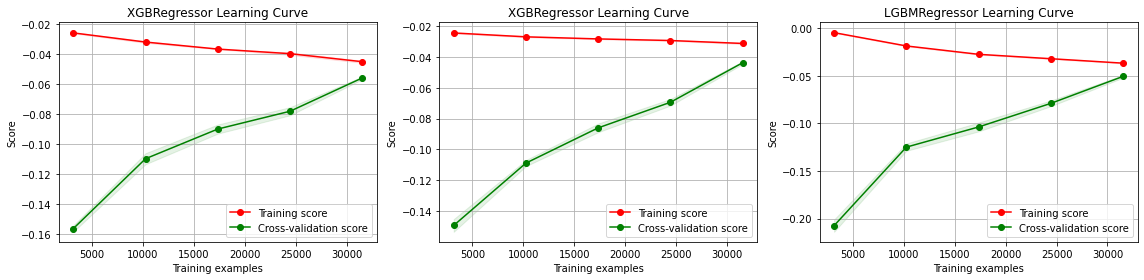

In [40]:
fig=plt.figure(figsize=(16,4))
for i, model in enumerate(models):
    ax=fig.add_subplot(1,3,i+1)
    plot_lear_curve(feats, model, kf, 'neg_mean_squared_error', ax=ax)
fig.tight_layout()
plt.show()

##Feature Selection 

In [61]:
# select top25 features
selected_feats = ['year',
                  'dayofyear',
                  'weekday',
                  'hour',
                  'visibility',
                  'humidity',
                  'apparentTemperature',
                  'mean_apparentTemperature_per_month',
                  'temperature',
                  'mean_temperature_per_month',
                  'dewPoint',
                  'dewPoint_rolling168h',
                  'windSpeed_lag1h',
                  'windSpeed_rolling12h',
                  'windSpeed_rolling24h',
                  'windBearing_lag1h',
                  'windBearing_rolling72h',
                  'uvIndex_rolling168h',
                  'temperature_24-72h_ma_diff',
                  'windSpeed_24-72h_ma_diff',
                  'windBearing_24-72h_ma_diff',
                  'humidity_24-72h_ma_diff'
                  ]

In [43]:
# select top20 features ### best performing so far ###
selected_feats2 = ['year',
                  'dayofyear',
                  'weekday',
                  'hour',
                  'visibility',
                  'humidity',
                  'apparentTemperature',
                  'mean_apparentTemperature_per_month',
                  'temperature',
                  'temperature_rolling168h',
                  'mean_temperature_per_month',
                  'dewPoint',
                  'dewPoint_rolling168h',
                  'windSpeed_lag1h',
                  'windSpeed_rolling12h',
                  'windSpeed_rolling24h',
                  'windBearing_lag1h',
                  'windBearing_rolling168h',
                  'windBearing_rolling72h',
                  'uvIndex_rolling168h'
                  ]

##Parameters tuning with HyperOpt on selected features

###XGBoost Depth-wise

In [62]:
X = df_train[selected_feats].values
y = df_train['PM25_nie_log'].values

def objective(space):
    
    XGB_model = xgb.XGBRegressor(n_estimators = space['n_estimators'],
                           max_depth = int(space['max_depth']),
                           min_child_weight = space['min_child_weight'],
                           subsample = space['subsample'],
                           learning_rate = space['learning_rate'],
                           gamma = space['gamma'],
                           colsample_bytree = space['colsample_bytree'],
                           objective='reg:squarederror',
                           tree_method='hist',
                           grow_policy='depthwise',
                           random_state=random_state
                           )
    
    for train_idx, test_idx in kf.split(X):

        eval_set = [(X[train_idx], y[train_idx]), (X[test_idx], y[test_idx])]
        XGB_model.fit(X[train_idx], y[train_idx], eval_set=eval_set, eval_metric = 'rmse', early_stopping_rounds=10, verbose=False)
        y_pred = XGB_model.predict(X[test_idx])

        rmse = np.sqrt(mean_squared_error(y[test_idx], y_pred))
        r2 = r2_score(y[test_idx], y_pred)
        
        print("RMSE: {:.4f}, r2: {:.1f}%".format(rmse, 100*r2))
        return{'loss': rmse, 'status': STATUS_OK }
    
    
space ={
        'max_depth': hp.choice('max_depth', np.arange(2, 8, 1, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
        'subsample': hp.uniform('subsample', 0.7, 1),
        'n_estimators' : hp.choice('n_estimators', np.arange(10, 500, 2, dtype=int)),
        'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05)
    }

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=10,
            trials=trials)

print("The best params: ", best)

RMSE: 0.2214, r2: 86.9%
RMSE: 0.2580, r2: 82.2%
RMSE: 0.2218, r2: 86.9%
RMSE: 0.2202, r2: 87.1%
RMSE: 0.2779, r2: 79.4%
RMSE: 0.2458, r2: 83.9%
RMSE: 0.2992, r2: 76.1%
RMSE: 0.2416, r2: 84.4%
RMSE: 0.2306, r2: 85.8%
RMSE: 0.2229, r2: 86.7%
100%|██████████| 10/10 [00:51<00:00,  5.18s/it, best loss: 0.2201922946036423]
The best params:  {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.47500000000000003, 'max_depth': 3, 'min_child_weight': 2.0, 'n_estimators': 85, 'subsample': 0.9938674967323975}


In [63]:
# initite models with best parameters
XGB_model_depth_v2 = xgb.XGBRegressor(**best, objective='reg:squarederror', tree_method='hist', grow_policy='depthwise', random_state=random_state)

###XGBoost Leaf-wise

In [64]:
def objective(space):
    
    XGB_model = xgb.XGBRegressor(n_estimators = space['n_estimators'],
                           max_depth = int(space['max_depth']),
                           min_child_weight = space['min_child_weight'],
                           subsample = space['subsample'],
                           learning_rate = space['learning_rate'],
                           gamma = space['gamma'],
                           colsample_bytree = space['colsample_bytree'],
                           objective='reg:squarederror',
                           tree_method='hist',
                           grow_policy='lossguide',
                           random_state=random_state
                           )
    
    for train_idx, test_idx in kf.split(X):

        eval_set = [(X[train_idx], y[train_idx]), (X[test_idx], y[test_idx])]
        XGB_model.fit(X[train_idx], y[train_idx], eval_set=eval_set, eval_metric = 'rmse', early_stopping_rounds=10, verbose=False)
        y_pred = XGB_model.predict(X[test_idx])

        rmse = np.sqrt(mean_squared_error(y[test_idx], y_pred))
        r2 = r2_score(y[test_idx], y_pred)
        
        print("RMSE: {:.4f}, r2: {:.1f}%".format(rmse, 100*r2))
        return{'loss': rmse, 'status': STATUS_OK }
    
    
space ={
        'max_depth': hp.choice('max_depth', np.arange(2, 8, 1, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
        'subsample': hp.uniform('subsample', 0.7, 1),
        'n_estimators' : hp.choice('n_estimators', np.arange(10, 500, 2, dtype=int)),
        'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05)
    }

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=10,
            trials=trials)

print("The best params: ", best)

RMSE: 0.2986, r2: 76.2%
RMSE: 0.2985, r2: 76.2%
RMSE: 0.2286, r2: 86.1%
RMSE: 0.2108, r2: 88.1%
RMSE: 0.2452, r2: 84.0%
RMSE: 0.6945, r2: -28.7%
RMSE: 0.2374, r2: 85.0%
RMSE: 0.2668, r2: 81.0%
RMSE: 0.2090, r2: 88.3%
RMSE: 0.2292, r2: 86.0%
100%|██████████| 10/10 [01:08<00:00,  6.83s/it, best loss: 0.20897118880070545]
The best params:  {'colsample_bytree': 0.8, 'gamma': 0.6000000000000001, 'learning_rate': 0.17500000000000002, 'max_depth': 4, 'min_child_weight': 8.0, 'n_estimators': 219, 'subsample': 0.7958563867096674}


In [65]:
# initite models with best parameters
XGB_model_leaf_v2 = xgb.XGBRegressor(**best, objective='reg:squarederror', tree_method='hist', grow_policy='lossguide', random_state=random_state)

###LightGBM

In [66]:
def objective(space):
    
    LGBM_model = lgb.LGBMRegressor(
                max_depth = int(space['max_depth']),
                n_estimators = space['n_estimators'],
                num_leaves = space['num_leaves'],
                min_child_weight = space['min_child_weight'],
                subsample = space['subsample'],
                learning_rate = space['learning_rate'],
                gamma = space['gamma'],
                colsample_bytree = space['colsample_bytree'],
                objective='regression',
                random_state=random_state
                )
    
    for train_idx, test_idx in kf.split(X):

        eval_set  = [(X[train_idx], y[train_idx]), (X[test_idx], y[test_idx])]
        LGBM_model.fit(X[train_idx], y[train_idx], eval_set=eval_set, eval_metric = 'rmse', early_stopping_rounds=10, verbose=False)
        y_pred = LGBM_model.predict(X[test_idx])

        rmse = np.sqrt(mean_squared_error(y[test_idx], y_pred))
        r2 = r2_score(y[test_idx], y_pred)
        
        print("RMSE: {:.4f}, r2: {:.1f}%".format(rmse, 100*r2))
        return{'loss': rmse, 'status': STATUS_OK }
    
    
space ={
        'max_depth': hp.choice ('max_depth', np.arange(2, 8, 1, dtype=int)),
        'n_estimators' : hp.choice('n_estimators', np.arange(10, 500, 2, dtype=int)),
        'num_leaves' : hp.choice('num_leaves', np.arange(10, 30, 1, dtype=int)),
        'min_child_weight': hp.quniform ('min_child', 1, 10, 1),
        'subsample': hp.uniform ('subsample', 0.7, 1),
        'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05)
        }

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=10,
            trials=trials)

print("The best params: ", best)

RMSE: 0.2772, r2: 79.5%
RMSE: 0.3123, r2: 74.0%
RMSE: 0.3307, r2: 70.8%
RMSE: 0.2853, r2: 78.3%
RMSE: 0.2822, r2: 78.8%
RMSE: 0.2600, r2: 82.0%
RMSE: 0.2616, r2: 81.7%
RMSE: 0.2307, r2: 85.8%
RMSE: 0.2297, r2: 85.9%
RMSE: 0.2011, r2: 89.2%
100%|██████████| 10/10 [00:12<00:00,  1.22s/it, best loss: 0.20114471032335013]
The best params:  {'colsample_bytree': 0.6000000000000001, 'gamma': 0.6000000000000001, 'learning_rate': 0.5, 'max_depth': 3, 'min_child': 8.0, 'n_estimators': 179, 'num_leaves': 8, 'subsample': 0.8632229272195804}


In [67]:
# initite models with best parameters
LGBM_model_v2 = lgb.LGBMRegressor(**best, objective='regression', random_state=random_state)

###Models evaluation

In [68]:
models = [XGB_model_depth_v2, XGB_model_leaf_v2, LGBM_model_v2]

for model in models:
    run_model(selected_feats, model, kf)

XGBRegressor RMSE: 0.2879, r2: 77.7%
XGBRegressor RMSE: 0.2512, r2: 83.1%
LGBMRegressor RMSE: 0.2639, r2: 81.3%


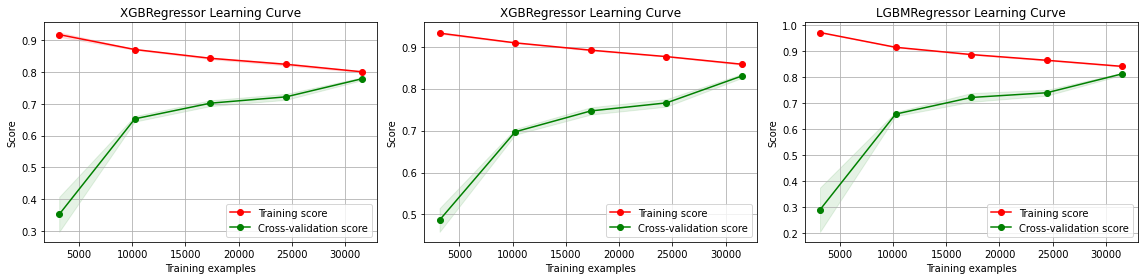

In [69]:
fig=plt.figure(figsize=(16,4))
for i, model in enumerate(models):
    ax=fig.add_subplot(1,3,i+1)
    plot_lear_curve(selected_feats, model, kf, 'r2', ax=ax)
fig.tight_layout()
plt.show()

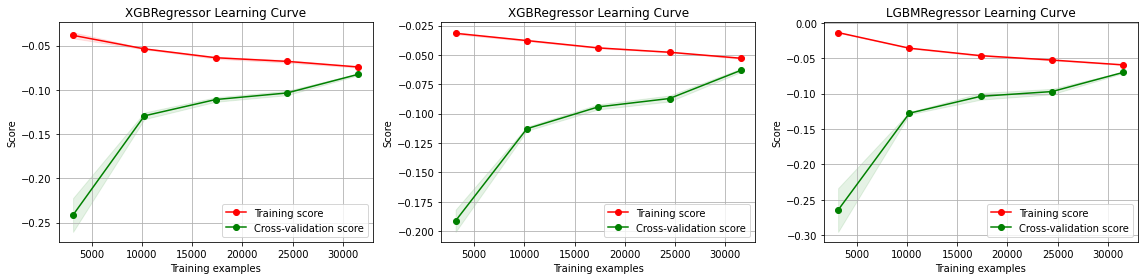

In [70]:
fig=plt.figure(figsize=(16,4))
for i, model in enumerate(models):
    ax=fig.add_subplot(1,3,i+1)
    plot_lear_curve(selected_feats, model, kf, 'neg_mean_squared_error', ax=ax)
fig.tight_layout()
plt.show()

## Predict on test data

In [71]:
# prepare X train for training on all feats and selected feats
X_train = df_train[feats].values
X_train_v2 = df_train[selected_feats].values

# prepare X test for predicting on all feats and selected feats
X_test = df_test[feats].values
X_test_v2 = df_test[selected_feats].values

# prepare y
y = df_train['PM25_nie_log'].values

In [72]:
# fit models on all feats
XGB_model_depth.fit(X_train, y)
XGB_model_leaf.fit(X_train, y)
LGBM_model.fit(X_train, y)

# predict on all feats 
y_test_XGB_depth = XGB_model_depth.predict(X_test)
y_test_XGB_leaf = XGB_model_leaf.predict(X_test)
y_test_LGBM = LGBM_model.predict(X_test)

# assign predicted results back to the dataframe and redo the log transformation
df_test['PM25_nie_pred_xgb_depth'] = np.expm1(y_test_XGB_depth)
df_test['PM25_nie_pred_xgb_leaf'] = np.expm1(y_test_XGB_leaf)
df_test['PM25_nie_pred_lgbm'] = np.expm1(y_test_LGBM)

In [73]:
# fit models on selected feats
XGB_model_depth_v2.fit(X_train_v2, y)
XGB_model_leaf_v2.fit(X_train_v2, y)
LGBM_model_v2.fit(X_train_v2, y)

# predict on selected feats
y_test_XGB_depth_v2 = XGB_model_depth_v2.predict(X_test_v2)
y_test_XGB_leaf_v2 = XGB_model_leaf_v2.predict(X_test_v2)
y_test_LGBM_v2 = LGBM_model_v2.predict(X_test_v2)

# assign predicted results back to the dataframe and redo the log transformation
df_test['PM25_nie_pred_xgb_depth_v2'] = np.expm1(y_test_XGB_depth_v2)
df_test['PM25_nie_pred_xgb_leaf_v2'] = np.expm1(y_test_XGB_leaf_v2)
df_test['PM25_nie_pred_lgbm_v2'] = np.expm1(y_test_LGBM_v2)

In [74]:
# check RMSE for test data on all feats
xgb_rmse_depth = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_depth']))
xgb_rmse_leaf = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_leaf']))
lgbm_rmse = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_lgbm']))

# check r2 for test data on all feats
xgb_r2_depth = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_depth'])
xgb_r2_leaf = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_leaf'])
lgbm_r2 = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_lgbm'])


# check RMSE for test data on selected feats
xgb_rmse_depth_v2 = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_depth_v2']))
xgb_rmse_leaf_v2 = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_leaf_v2']))
lgbm_rmse_v2 = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_lgbm_v2']))

# check r2 for test data for both Light GBM models
xgb_r2_depth_v2 = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_depth_v2'])
xgb_r2_leaf_v2 = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_leaf_v2'])
lgbm_r2_v2 = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_lgbm_v2'])

In [75]:
print("-----RMSE and r2 results on the test data using all features-----")
print("XGBoost_Depth: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_depth, 100*np.mean(xgb_r2_depth)))
print("XGBoost_Leaf: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_leaf, 100*np.mean(xgb_r2_leaf)))
print("LightGBM: RMSE: {:.4f}, r2: {:.1f}%".format(lgbm_rmse, 100*np.mean(lgbm_r2)))
print(" ")
print("-----RMSE and r2 results on the test data using selected features-----")
print("XGBoost_Depth_v2: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_depth_v2, 100*np.mean(xgb_r2_depth_v2)))
print("XGBoost_Leaf_v2: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_leaf_v2, 100*np.mean(xgb_r2_leaf_v2)))
print("LightGBM_v2: RMSE: {:.4f}, r2: {:.1f}%".format(lgbm_rmse_v2, 100*np.mean(lgbm_r2_v2)))

-----RMSE and r2 results on the test data using all features-----
XGBoost_Depth: RMSE: 7.1949, r2: 52.7%
XGBoost_Leaf: RMSE: 7.1138, r2: 53.8%
LightGBM: RMSE: 8.1017, r2: 40.0%
 
-----RMSE and r2 results on the test data using selected features-----
XGBoost_Depth_v2: RMSE: 6.9169, r2: 56.3%
XGBoost_Leaf_v2: RMSE: 7.1073, r2: 53.9%
LightGBM_v2: RMSE: 7.9179, r2: 42.7%


In [76]:
months = df_test.month.unique().tolist()
months

[7, 8, 9, 10, 11, 12]

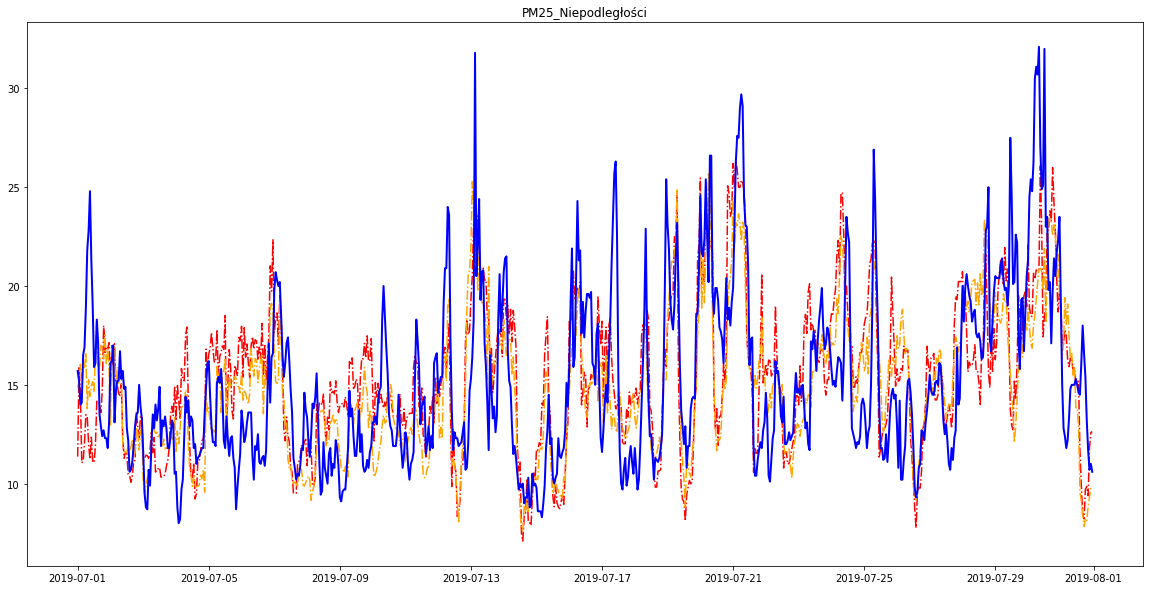

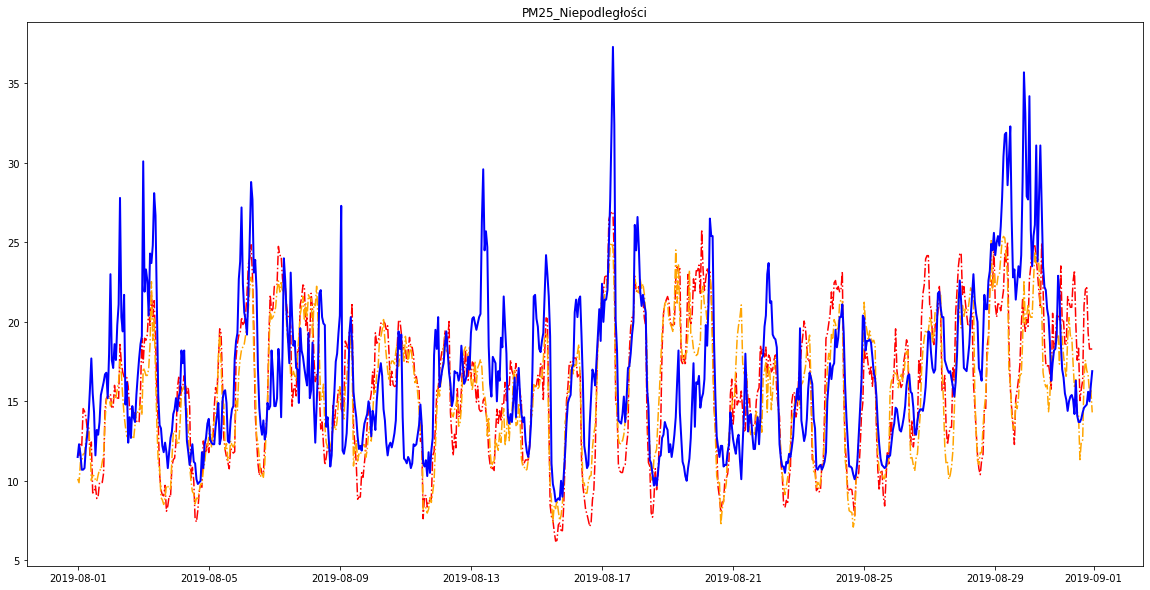

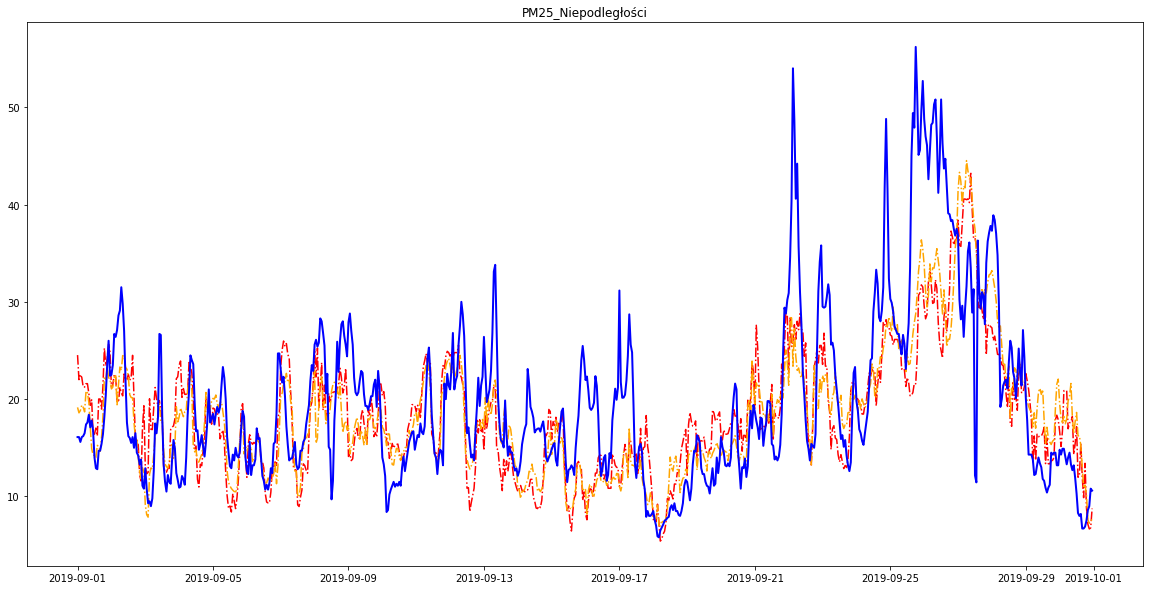

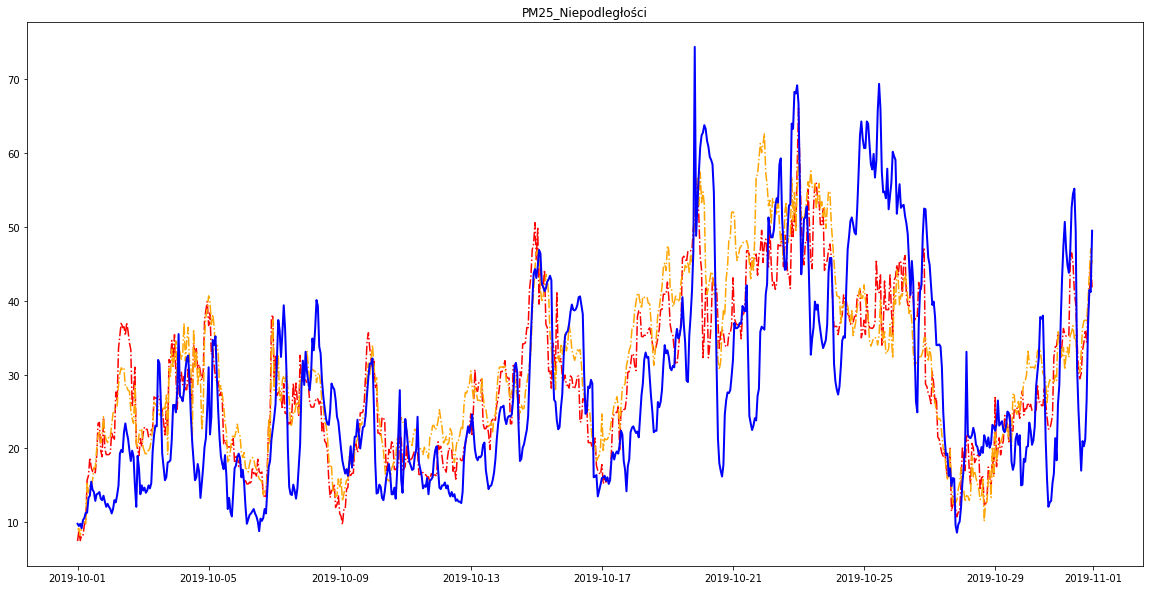

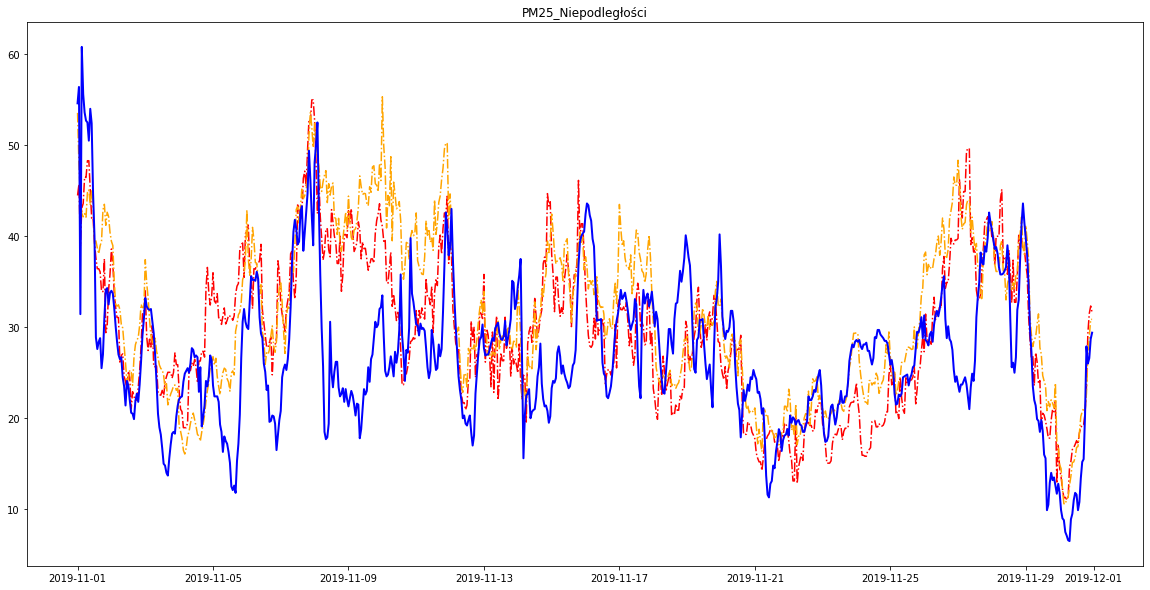

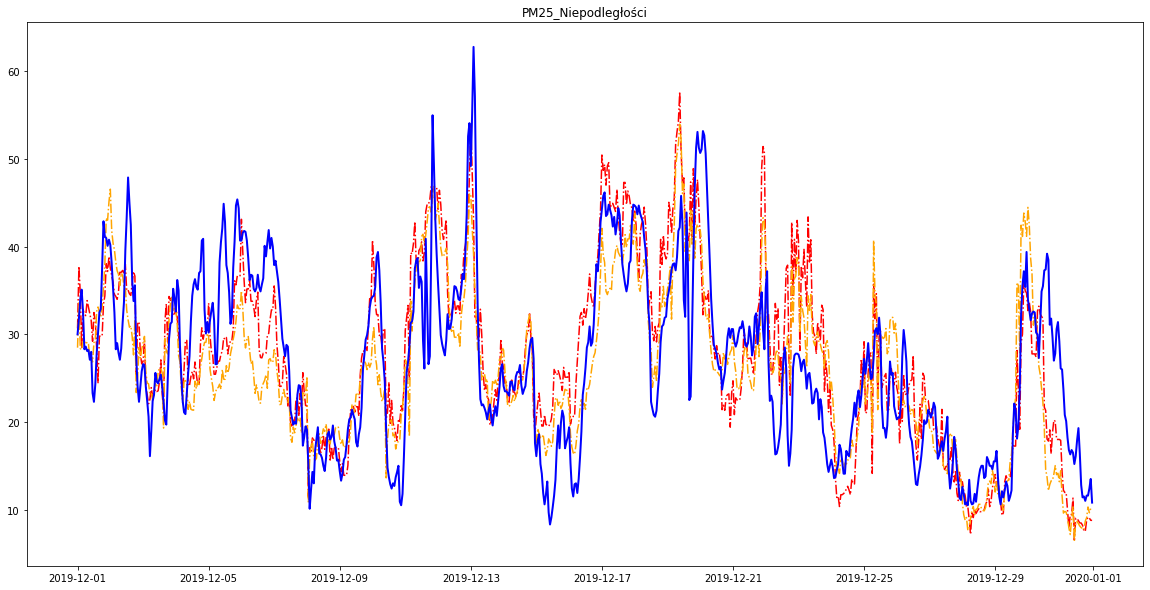

In [77]:
for mth in months:
    test_mask = df_test['month'] == mth
    plt.figure(figsize=(20,10))
    plt.plot(df_test.loc[test_mask]['datetime'], df_test.loc[test_mask]['PM25_nie_pred_xgb_depth_v2'], color='red', linestyle='dashdot') #forecast
    plt.plot(df_test.loc[test_mask]['datetime'], df_test.loc[test_mask]['PM25_nie_pred_xgb_leaf_v2'], color='orange', linestyle='dashdot') #forecast
    plt.plot(df_test.loc[test_mask]['datetime'], df_test.loc[test_mask]['PM25_nie'], color='blue', linewidth = 2) #actual

    plt.title('PM25_Niepodległości')
    plt.show()